In [1]:
!pip install numpy
!pip install matplotlib
!pip install mpl_toolkits

azure-cli-interactive 0.3.22 has requirement six~=1.11.0, but you'll have six 1.10.0 which is incompatible.
azure-cli-core 2.0.35 has requirement pyopenssl>=17.1.0, but you'll have pyopenssl 16.2.0 which is incompatible.
pyasn1-modules 0.2.1 has requirement pyasn1<0.5.0,>=0.4.1, but you'll have pyasn1 0.1.9 which is incompatible.
azure-cli-core 2.0.35 has requirement pyopenssl>=17.1.0, but you'll have pyopenssl 16.2.0 which is incompatible.
azure-cli-interactive 0.3.22 has requirement six~=1.11.0, but you'll have six 1.10.0 which is incompatible.
pyasn1-modules 0.2.1 has requirement pyasn1<0.5.0,>=0.4.1, but you'll have pyasn1 0.1.9 which is incompatible.
  Could not find a version that satisfies the requirement mpl_toolkits (from versions: )
No matching distribution found for mpl_toolkits


In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
ACTION_HIT = 0
ACTION_STAND = 1
actions = [ACTION_HIT, ACTION_STAND]

In [4]:
policyPlayer = np.zeros(22)
for i in range(12, 20):
    policyPlayer[i] = ACTION_HIT

In [5]:
policyPlayer[20] = ACTION_STAND
policyPlayer[21] = ACTION_STAND

In [6]:
def targetPolicyPlayer(usableAcePlayer, playerSum, dealerCard):
    return policyPlayer[playerSum]

In [7]:
def behaviorPolicyPlayer(usableAcePlayer, playerSum, dealerCard):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT

In [8]:
policyDealer = np.zeros(22)
for i in range(12, 17):
    policyDealer[i] = ACTION_HIT
for i in range(17, 22):
    policyDealer[i] = ACTION_STAND

In [9]:
def getCard():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

In [10]:
def play(policyPlayerFn, initialState=None, initialAction=None):
    playerSum = 0
    playerTrajectory = []
    usableAcePlayer = False
    dealerCard1 = 0
    dealerCard2 = 0
    usableAceDealer = False
    
    if initialState is None:
        numOfAce = 0
        while playerSum < 12:
            card = getCard()
            if card == 1:
                numOfAce += 1
                card = 11
                usableAcePlayer = True
            playerSum += card
        if playerSum > 21:
            playerSum -= 10
            if numOfAce == 1:
                usableAcePlayer = False
        dealerCard1 = getCard()
        dealerCard2 = getCard()
    else:
        usableAcePlayer = initialState[0]
        playerSum = initialState[1]
        dealerCard1 = initialState[2]
        dealerCard2 = getCard()
    state = [usableAcePlayer, playerSum, dealerCard1]
    dealerSum = 0
    if dealerCard1 == 1 and dealerCard2 != 1:
        dealerSum += 11 + dealerCard2
        usableAceDealer = True
    elif dealerCard1 != 1 and dealerCard2 == 1:
        dealerSum += dealerCard1 + 11
        usableAceDealer = True
    elif dealerCard1 == 1 and dealerCard2 == 1:
        dealerSum += 1 + 11
        usableAceDealer = True
    else:
        dealerSum += dealerCard1 + dealerCard2
        
    while True:
        if initialAction is not None:
            action = initialAction
            initialAction = None
        else:
            action = policyPlayerFn(usableAcePlayer, playerSum, dealerCard1)
            
        playerTrajectory.append([action, (usableAcePlayer, playerSum, dealerCard1)])
        if action == ACTION_STAND:
            break
            
        playerSum += getCard()
        if playerSum > 21:
            if usableAcePlayer == True:
                playerSum -= 10
                usableAcePlayer = False
            else:
                return state, -1, playerTrajectory
            
    while True:
        action = policyDealer[dealerSum]
        if action == ACTION_STAND:
            break
        dealerSum += getCard()
        if dealerSum > 21:
            if usableAceDealer == True:
                dealerSum -= 10
                usableAceDealer = False
            else:
                return state, 1, playerTrajectory
            
    if playerSum > dealerSum:
        return state, 1, playerTrajectory
    elif playerSum == dealerSum:
        return state, 0, playerTrajectory
    else:
        return state, -1, playerTrajectory

In [11]:
def monteCarloOnPolicy(nEpisodes):
    statesUsableAce = np.zeros((10, 10))
    statesUsableAceCount = np.ones((10, 10))
    statesNoUsableAce = np.zeros((10, 10))
    statesNoUsableAceCount = np.ones((10, 10))
    for i in range(0, nEpisodes):
        state, reward, _ = play(targetPolicyPlayer)
        state[1] -= 12
        state[2] -= 1
        if state[0]:
            statesUsableAceCount[state[1], state[2]] += 1
            statesUsableAce[state[1], state[2]] += reward
        else:
            statesNoUsableAceCount[state[1], state[2]] += 1
            statesNoUsableAce[state[1], state[2]] += reward
    return statesUsableAce / statesUsableAceCount, statesNoUsableAce / statesNoUsableAceCount

In [12]:
def monteCarloES(nEpisodes):
    stateActionValues = np.zeros((10, 10, 2, 2))
    stateActionPairCount = np.ones((10, 10, 2, 2))
    
    def behaviorPolicy(usableAce, playerSum, dealerCard):
        usableAce = int(usableAce)
        playerSum -= 12
        dealerCard -= 1
        return np.argmax(stateActionValues[playerSum, dealerCard, usableAce, :] / stateActionPairCount[playerSum, dealerCard, usableAce, :])
    
    for episode in range(nEpisodes):
        if episode % 100000 == 0:
            print('Episode:', episode)
        initialState = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initialAction = np.random.choice(actions)
        _, reward, trajectory = play(behaviorPolicy, initialState, initialAction)
        
        for action, (usableAce, playerSum, dealerCard) in trajectory:
            usableAce = int(usableAce)
            playerSum -= 12
            dealerCard -= 1
            stateActionValues[playerSum, dealerCard, usableAce, action] += reward
            stateActionPairCount[playerSum, dealerCard, usableAce, action] += 1
            
    return stateActionValues / stateActionPairCount

In [13]:
figureIndex = 0
def prettyPrint(data, title, zlabel='reward'):
    global figureIndex
    fig = plt.figure(figureIndex)
    figureIndex += 1
    fig.suptitle(title)
    ax = fig.add_subplot(111, projection='3d')
    x_axis = []
    y_axis = []
    z_axis = []
    for i in range(12, 22):
        for j in range(1, 11):
            x_axis.append(i)
            y_axis.append(j)
            z_axis.append(data[i - 12, j - 1])
    ax.scatter(x_axis, y_axis, z_axis, c='red')
    ax.set_xlabel('player sum')
    ax.set_ylabel('dealer showing')
    ax.set_zlabel(zlabel)

In [14]:
def onPolicy():
    statesUsableAce1, statesNoUsableAce1 = monteCarloOnPolicy(10000)
    statesUsableAce2, statesNoUsableAce2 = monteCarloOnPolicy(500000)
    prettyPrint(statesUsableAce1, 'Usable Ace & 10000 Episodes')
    prettyPrint(statesNoUsableAce1, 'No Usable Ace & 10000 Episodes')
    prettyPrint(statesUsableAce2, 'Usable Ace & 500000 Episodes')
    prettyPrint(statesNoUsableAce2, 'No Usable Ace & 500000 Episodes')
    plt.show()

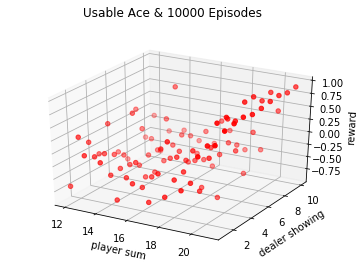

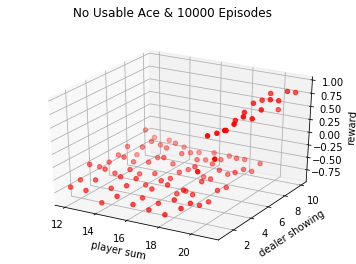

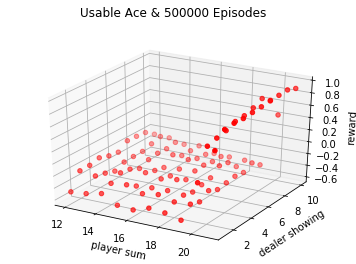

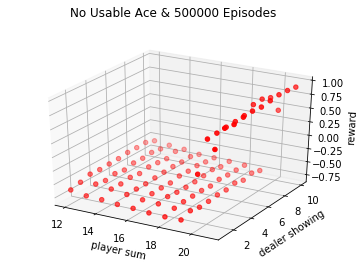

In [15]:
onPolicy()

In [16]:
def MC_ES_optimalPolicy():
    stateActionValues = monteCarloES(500000)
    stateValueUsableAce = np.zeros((10, 10))
    stateValueNoUsableAce = np.zeros((10, 10))
    actionUsableAce = np.zeros((10, 10), dtype='int')
    actionNoUsableAce = np.zeros((10, 10), dtype='int')
    
    for i in range(10):
        for j in range(10):
            stateValueNoUsableAce[i, j] = np.max(stateActionValues[i, j, 0, :])
            stateValueUsableAce[i, j] = np.max(stateActionValues[i, j, 1, :])
            actionNoUsableAce[i, j] = np.argmax(stateActionValues[i, j, 0, :])
            actionUsableAce[i, j] = np.argmax(stateActionValues[i, j, 1, :])
    
    prettyPrint(stateValueUsableAce, 'Optimal state value with usable Ace')
    prettyPrint(stateValueNoUsableAce, 'Optimal state value with no usable Ace')
    prettyPrint(actionUsableAce, 'Optimal policy with usable Ace', 'Action(0 Hit, 1 Stick)')
    prettyPrint(actionNoUsableAce, 'Optimal policy with no usable Ace', 'Action (0 Hit, 1 Stick)')
    plt.show()

Episode: 0
Episode: 100000
Episode: 200000
Episode: 300000
Episode: 400000


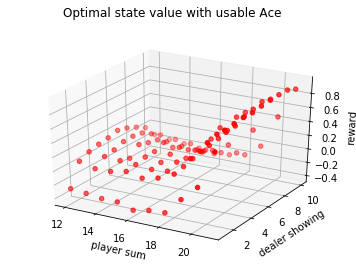

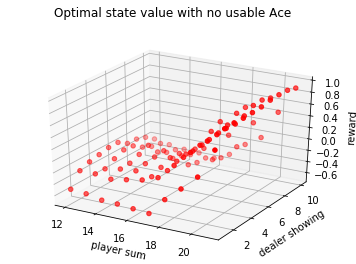

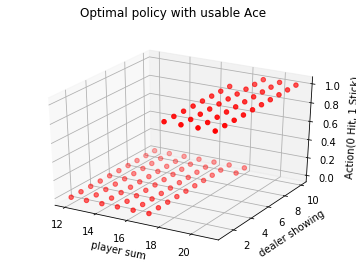

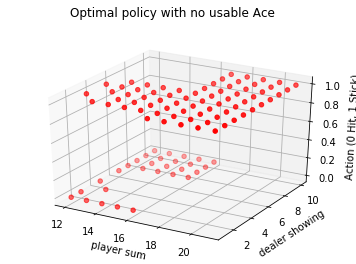

In [17]:
MC_ES_optimalPolicy()